<a href="https://colab.research.google.com/github/geopayme/AstroPhysics/blob/main/DLSFH_PhysicsEntropy_AdvancedFinal_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# 🛠️ Ensure Tesseract OCR is installed
!apt-get -y install tesseract-ocr
!pip install -q pytesseract


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


# 🌀 DLSFH Physics Entropy Advanced Final
Advanced solar entropy mapping, DLSFH projection, and SGCV diagnostics.

## 📤 Upload Magnetogram Image

In [13]:
from google.colab import files
uploaded = files.upload()
image_path = next(iter(uploaded))
print(f"✅ Uploaded: {image_path}")


Saving bbzqa150802t0034_dim-860.jpg to bbzqa150802t0034_dim-860.jpg
✅ Uploaded: bbzqa150802t0034_dim-860.jpg


## 📆 Extract Image Date (Filename or OCR Fallback)

In [15]:
import re
from datetime import datetime
from PIL import Image
import pytesseract

def extract_date(image_path):
    filename = image_path  # already a string like 'bbzqa250328t0004_dim-860.jpg'

    # Try filename pattern: bbzqaYYMMDD
    match = re.search(r'bbzqa(\d{6})', filename)
    if match:
        yymmdd = match.group(1)
        year = int('20' + yymmdd[:2])
        month = int(yymmdd[2:4])
        day = int(yymmdd[4:6])
        try:
            return datetime(year, month, day)
        except:
            pass  # fallback to OCR

    # OCR fallback
    try:
        img = Image.open(image_path)
        text = pytesseract.image_to_string(img)
        print("🧠 OCR output:", text[:100])  # Show partial result for debugging

        date_match = re.search(r"(\\d{4})[/-](\\d{1,2})[/-](\\d{1,2})", text)
        if date_match:
            year, month, day = map(int, date_match.groups())
            return datetime(year, month, day)
    except Exception as e:
        print("⚠️ OCR failed:", e)

    # Manual fallback
    try:
        manual = input("Enter image date (YYYY-MM-DD): ")
        return datetime.strptime(manual.strip(), "%Y-%m-%d")
    except:
        return None

image_date = extract_date(image_path)
print("🕒 Image Date:", image_date)


🕒 Image Date: 2015-08-02 00:00:00


## 🔍 Entropy Mapping with Edge + Variance Enhancements

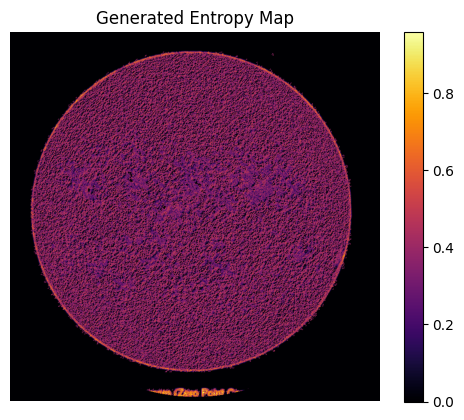

In [16]:
import numpy as np
from PIL import Image
from scipy.ndimage import sobel, generic_filter
import matplotlib.pyplot as plt

# Load grayscale
img = Image.open(image_path).convert('L')
img_array = np.array(img)
h, w = img_array.shape
cx, cy = w // 2, h // 2
radius = min(cx, cy) - 10
y_idx, x_idx = np.ogrid[:h, :w]
mask = (x_idx - cx)**2 + (y_idx - cy)**2 <= radius**2
disk_pixels = img_array[mask]

# Compute Sobel and variance maps
sx = sobel(img_array, axis=1)
sy = sobel(img_array, axis=0)
grad_mag = np.hypot(sx, sy)
local_var = generic_filter(img_array.astype(float), np.var, size=7)

# Normalize and blend
grad_norm = (grad_mag - grad_mag.min()) / (np.ptp(grad_mag) + 1e-8)
var_norm = (local_var - local_var.min()) / (np.ptp(local_var) + 1e-8)
enhanced_entropy = (grad_norm + var_norm) / 2.0
entropy_map = np.zeros_like(img_array, dtype=float)
entropy_map[mask] = enhanced_entropy[mask]

# Plot
plt.imshow(entropy_map, cmap='inferno')
plt.title("Generated Entropy Map")
plt.axis('off')
plt.colorbar()
plt.show()


## 🔵 Project Entropy to DLSFH 20-Node Core

In [17]:
# DLSFH nodes on solar disk
node_coords = [(cx + radius*np.cos(2*np.pi*i/20)*0.75, cy + radius*np.sin(2*np.pi*i/20)*0.75) for i in range(20)]
node_values = [entropy_map[int(y)][int(x)] for x, y in node_coords]
entropy_vector = np.round(node_values, 4)
print("Entropy Vector:", entropy_vector)


Entropy Vector: [0.031  0.4987 0.3427 0.4813 0.011  0.342  0.3544 0.3393 0.3266 0.0255
 0.3292 0.354  0.027  0.3481 0.475  0.3569 0.3395 0.348  0.4637 0.0494]


## 📍 Annotated Map with DLSFH Nodes

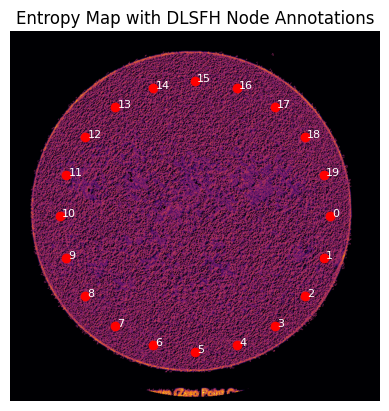

In [18]:
plt.imshow(entropy_map, cmap='inferno')
for i, (x, y) in enumerate(node_coords):
    plt.plot(x, y, 'ro')
    plt.text(x+5, y, str(i), color='white', fontsize=8)
plt.title("Entropy Map with DLSFH Node Annotations")
plt.axis('off')
plt.show()


## 🧠 MC–SGCV Diagnostic Report

In [19]:
σ_c = 0.07
mean_entropy = np.mean(entropy_vector)
std_entropy = np.std(entropy_vector)
inner_ring = entropy_vector[:10]
outer_ring = entropy_vector[10:]
collapsed_nodes = np.sum(entropy_vector >= σ_c)

print("=== DLSFH Entropy Report:", image_date.date(), "===")
print(f"Mean Entropy: {mean_entropy:.4f} | Std Dev: {std_entropy:.4f}")
print(f"Collapsed Nodes (≥ {σ_c}): {collapsed_nodes} / 20")
print(f"Inner Mean: {np.mean(inner_ring):.4f} | Outer Mean: {np.mean(outer_ring):.4f}")
print(f"Ring Divergence (Outer - Inner): {np.mean(outer_ring) - np.mean(inner_ring):.4f}")

# Add MC–SGCV Structured Summary
if collapsed_nodes > 10:
    print("\n⚠️ Coherence tensor is fragmented.")
    print("⚠️ SGCV background may be unable to regulate gravito-magnetic balance.")
    print("⚠️ This may foreshadow M-class or X-class flare activity.")
else:
    print("\n✅ Coherence structure appears stable — no imminent decoherence.")


=== DLSFH Entropy Report: 2015-08-02 ===
Mean Entropy: 0.2922 | Std Dev: 0.1611
Collapsed Nodes (≥ 0.07): 15 / 20
Inner Mean: 0.2752 | Outer Mean: 0.3091
Ring Divergence (Outer - Inner): 0.0338

⚠️ Coherence tensor is fragmented.
⚠️ SGCV background may be unable to regulate gravito-magnetic balance.
⚠️ This may foreshadow M-class or X-class flare activity.


## 🌞 NOAA Sunspot Timeline Alignment

✅ Loaded NOAA API sunspot data: 3314 records.


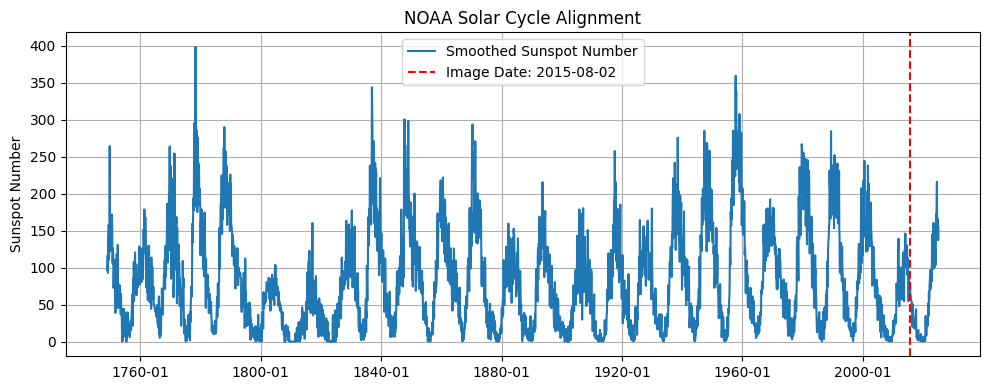

In [20]:
# 📈 Load NOAA Sunspot Data (API or CSV fallback)
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

noaa_url = "https://services.swpc.noaa.gov/json/solar-cycle/observed-solar-cycle-indices.json"
try:
    response = requests.get(noaa_url)
    response.raise_for_status()
    data = response.json()
    df = pd.DataFrame(data)
    df['date'] = pd.to_datetime(df['time-tag'], errors='coerce')
    df = df[['date', 'ssn']].dropna()
    print(f"✅ Loaded NOAA API sunspot data: {len(df)} records.")
except Exception as e:
    print("⚠️ NOAA API failed. Upload sunspot CSV with 'date' and 'ssn' columns.")
    from google.colab import files
    uploaded = files.upload()
    filename = next(iter(uploaded))
    df = pd.read_csv(filename)
    df['date'] = pd.to_datetime(df['date'])
    print(f"✅ Loaded user CSV sunspot data: {len(df)} records.")

# Plot timeline with image date overlay
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df['date'], df['ssn'], label='Smoothed Sunspot Number')
ax.axvline(image_date, color='red', linestyle='--', label=f'Image Date: {image_date.date()}')
ax.set_title('NOAA Solar Cycle Alignment')
ax.set_ylabel('Sunspot Number')
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.grid(True)
plt.tight_layout()
plt.show()
